# Stack Individual Residuals to find Sky Emission Lines or Systematic Errors

In [154]:
import astropy.io.fits as fits
import matplotlib.pylab as plt
import numpy as np
from scipy.signal import medfilt
from scipy.interpolate import interp1d
from scipy.interpolate import splev, splrep
import math
from mpmath import mp
import os
import os.path 
import random
from random import seed
from random import choice
from random import uniform
import mplcursors
import pandas as pd
from operator import itemgetter

from astropy import stats
import astropy


In [142]:
directory = '/mnt_home/azuckerman/BL_APF_DAP/APF_spectra/NDRR_ind'

residuals_target_list= pd.read_csv(
    '/mnt_home/zoek/code/APF-BL-DAP/Zoe/residual_target_list.csv')['Simbad_resolvable_name']

sp_results = pd.read_csv('/home/zoek/code/APF-BL-DAP/Zoe/specmatch_results_ind_8Apr2022.csv')

vel_shifts = pd.read_csv('/home/zoek/code/APF-BL-DAP/Zoe/FindRestWavelengths/Velocity_shift_ind.csv')

In [143]:
vel_shifts.sort_values('Velocity_shift [km/s]')

,Unnamed: 0,Star_name,Velocity_shift [km/s],X-corr_peak
2037,2037,HIP117795_2,-198.893605,3782.371648
2054,2054,HIP117795_5,-198.893605,179.278757
2075,2075,HIP117795_9,-195.849315,130.692829
2028,2028,HIP117795_0,-195.849315,479.551772
2082,2082,HIP117795_10,-183.672156,197.292883
...,...,...,...,...
2598,2598,HIP62207_0,180.627866,52.108578
2100,2100,TIC377064495_2,181.642629,106.240124
2070,2070,TIC377064495_1,181.642629,100.997057
2040,2040,TIC377064495_0,181.642629,109.924954


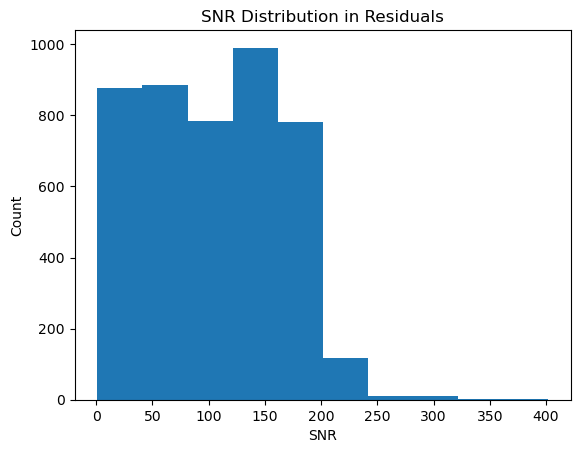

In [144]:
plt.hist(sp_results['SNR'])
plt.title('SNR Distribution in Residuals')
plt.xlabel('SNR')
plt.ylabel('Count')
plt.show()

In [168]:
len(sp_results)

5082

In [145]:
c = 3 * 10 ** 5 # km/s

def unshift(wl_grid, velshift):
    # given a array of wl values and a velocity shift in km/s,
    # shift the wavelength grid to the observed frame
    return (wl_grid * c) / (c - velshift)

In [146]:
# every file in Anna's NDRR folder that is also in the residual target list
list_of_files = []
for filename in os.listdir(directory):
    if filename.endswith(".fits"): 
        file_path = os.path.join(directory, filename)
        file = fits.open(file_path)
        header = file[0].header
        star = header['OBJECT']
        file.close()
        if residuals_target_list.str.contains(star).any():
            list_of_files = np.append(list_of_files, file_path)

In [147]:
fluxes = np.array([])

for which_star in np.arange(len(list_of_files)):
# for which_star in np.arange(30):

#     print(which_star)
    
    # Get one star from list of all stars
    APF_flux_path = list_of_files[which_star]
    
    identifier = APF_flux_path.split('/')[-1]
    length = len(identifier)
    identifier = identifier[:length-10]

    file = fits.open(APF_flux_path)
    flux = file[1].data
    wl = file[2].data

    header = file[0].header
    star = header['OBJECT']
    
        
    # get SNR
    SNR = 0
    if sp_results['name'].str.contains(identifier).any():
        x = sp_results[sp_results['name'] == identifier]
        SNR = float(x['SNR'])
        
    if SNR < 100:
        continue
        
    # get vel shift val
    if vel_shifts['Star_name'].str.contains(identifier).any():
        x = vel_shifts[vel_shifts['Star_name'] == identifier]
        vel_shift = float(x['Velocity_shift [km/s]'])
        
        observed_wl = unshift(np.array(wl), vel_shift)
    
    mask = (observed_wl > 5004) & (observed_wl < 5895)
    observed_wl = observed_wl[mask]
    observed_fl = flux[mask]
    
    if len(observed_fl) == 48284:
        observed_wl = observed_wl[1:]
        observed_fl = observed_fl[1:]
    
#     plt.plot(wl, flux, label='shifted')
#     plt.plot(observed_wl, observed_fl, label='observed')
#     plt.legend()
#     plt.show()

    if len(fluxes) == 0:
        fluxes = np.array(observed_fl)
    else:
        fluxes = np.vstack([fluxes, np.array(observed_fl)])

In [155]:
percentile_50 = 50
stacked_fluxes_50 = np.apply_along_axis(lambda x: np.percentile(x, percentile_50), axis=0, arr=fluxes)

In [156]:
percentile_75 = 75
stacked_fluxes_75 = np.apply_along_axis(lambda x: np.percentile(x, percentile_75), axis=0, arr=fluxes)

In [157]:
percentile_90 = 90
stacked_fluxes_90 = np.apply_along_axis(lambda x: np.percentile(x, percentile_90), axis=0, arr=fluxes)

In [158]:
percentile_95 = 95
stacked_fluxes_95 = np.apply_along_axis(lambda x: np.percentile(x, percentile_95), axis=0, arr=fluxes)

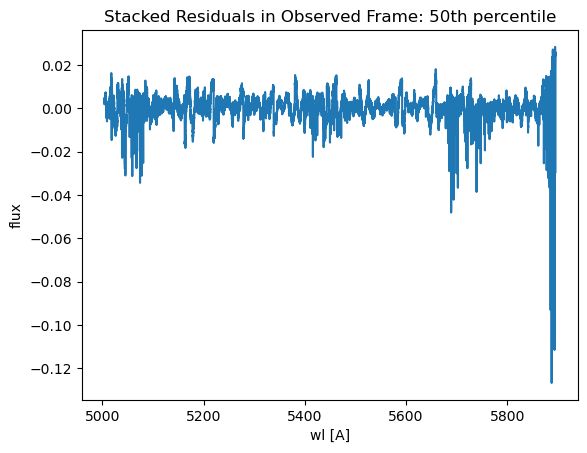

In [163]:
plt.plot(observed_wl, stacked_fluxes_50)
plt.title('Stacked Residuals in Observed Frame: 50th percentile')
plt.xlabel('wl [A]')
plt.ylabel('flux')
plt.show()

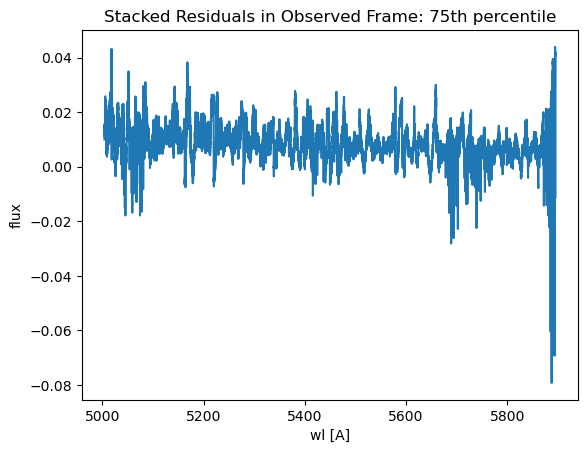

In [164]:
plt.plot(observed_wl, stacked_fluxes_75)
plt.title('Stacked Residuals in Observed Frame: 75th percentile')
plt.xlabel('wl [A]')
plt.ylabel('flux')
plt.show()

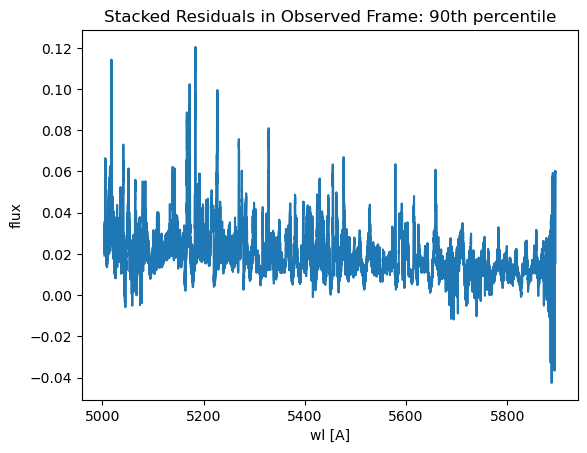

In [165]:
plt.plot(observed_wl, stacked_fluxes_90)
plt.title('Stacked Residuals in Observed Frame: 90th percentile')
plt.xlabel('wl [A]')
plt.ylabel('flux')
plt.show()

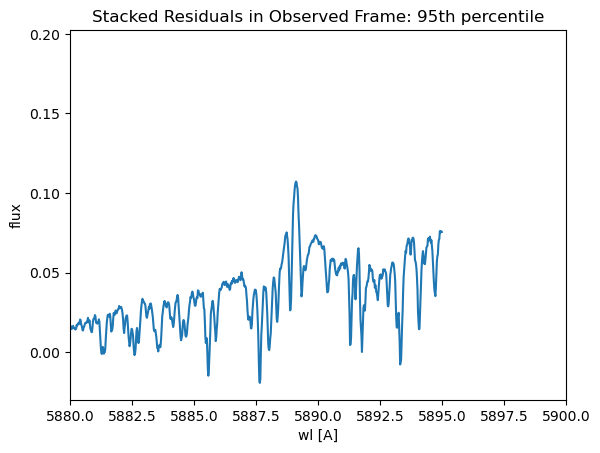

In [169]:
plt.plot(observed_wl, stacked_fluxes_95)
plt.xlim(5880, 5900)
plt.title('Stacked Residuals in Observed Frame: 95th percentile')
plt.xlabel('wl [A]')
plt.ylabel('flux')
plt.show()

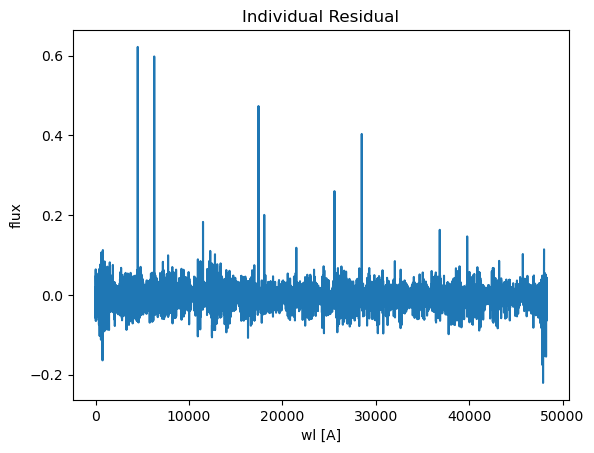

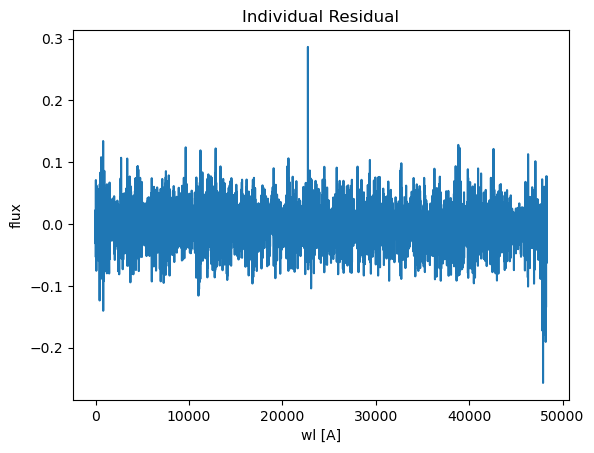

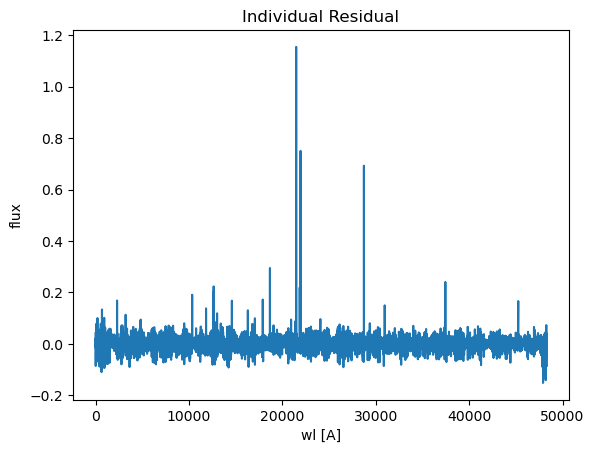

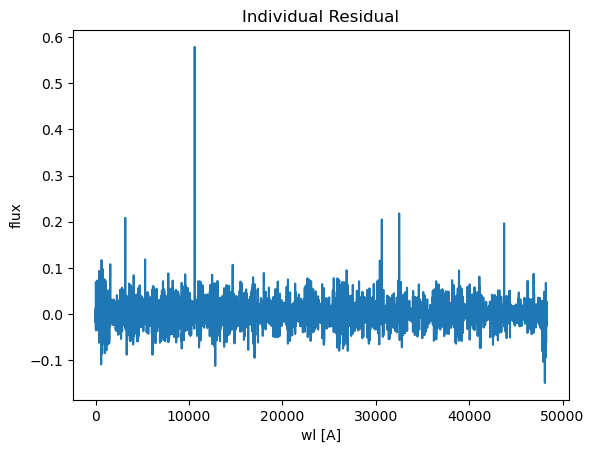

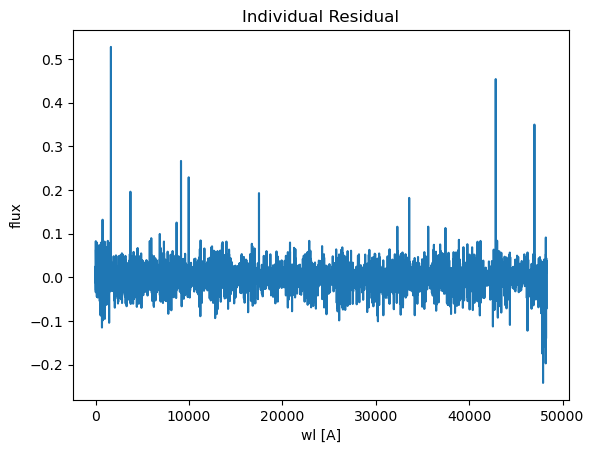

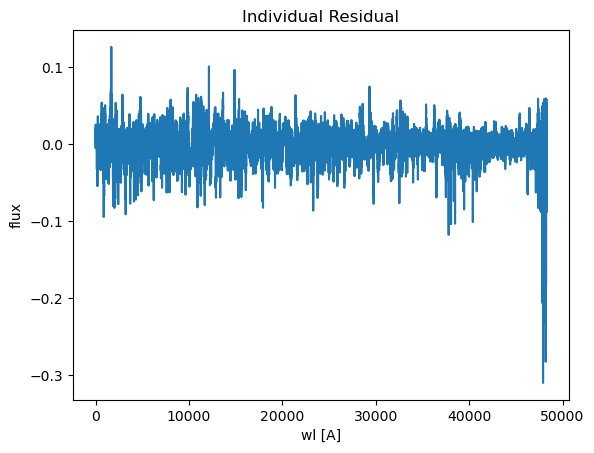

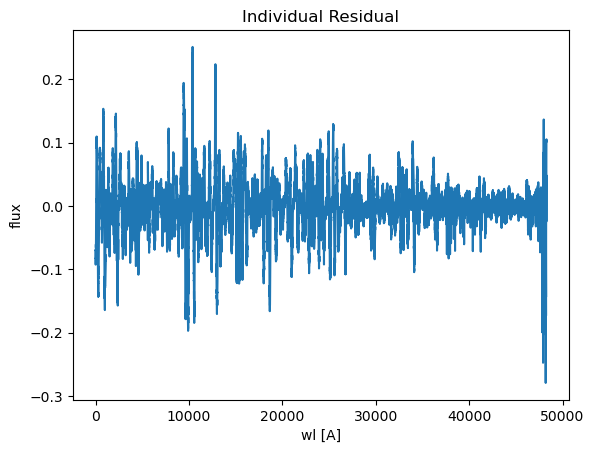

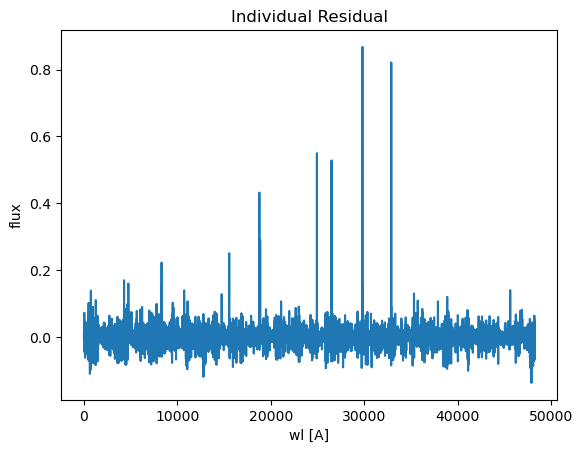

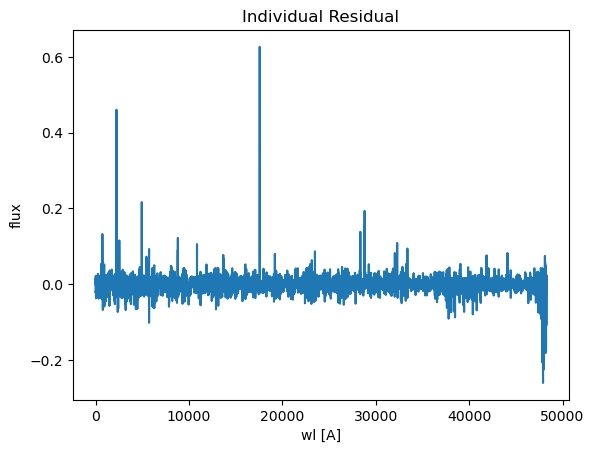

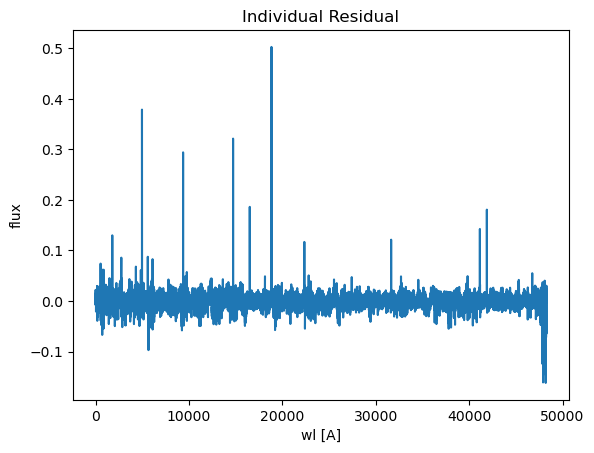

In [171]:
for flux in fluxes[:10]:
    plt.plot(flux)
    plt.title('Individual Residual')
    plt.xlabel('wl [A]')
    plt.ylabel('flux')
    plt.show()